# PCO2 Histogram

`cd project/seniorthesis/notebooks`

`conda list PyCO2SYS`

`pip install PyCO2SYS`

`pip install git+https://github.com/jbusecke/cmip6_preprocessing.git`

`mv *.png ../figures`

In [1]:
import xarray as xr
import xesmf as xe
from cmip6_preprocessing.preprocessing import combined_preprocessing
import PyCO2SYS as pyco2 # i have to install this package through terminal for it to work
import intake
import matplotlib.pyplot as plt
import numpy as np
import warnings
import gsw
from cmip6_preprocessing.postprocessing import combine_datasets
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import cmocean
import matplotlib.path as mpath
from cmip6_preprocessing.postprocessing import combine_datasets
from cmip6_preprocessing.postprocessing import merge_variables
from dask.diagnostics import ProgressBar
from xgcm import Grid
from xhistogram.xarray import histogram
import pandas as pd
import scipy

## Area

In [2]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

def pick_first_member(ds_list, **kwargs):
    return ds_list[0]

variables = ['areacello']
z_kwargs = {'consolidated': True, 'use_cftime': True}
query = dict(experiment_id=['historical'], 
             table_id=['Ofx'], 
             variable_id=variables,
             grid_label=['gr'],
              source_id=['GFDL-ESM4']
            )


cat = col.search(**query)

# print(cat.df['source_id'].unique())
dd_A = cat.to_dataset_dict(zarr_kwargs=z_kwargs, storage_options={'token': 'anon'},
                                preprocess=combined_preprocessing, aggregate=False)

# dd_gr = merge_variables(dd_gr)

# temp={}
# for name,item in dd_gr.items():
#     #print(name)
#     #print(item.data_vars)
#     present = item.data_vars
#     if all(i in present for i in variables):
#         #print(name)
#         temp[name]=item
# dd_gr = temp
# list(dd_new_gr.keys())

dd_A = combine_datasets(
    dd_A,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id']
)
list(dd_A.keys())
# dd_new_new_gr


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


['GFDL-ESM4.gr.historical.Ofx']

In [3]:
dd_A['GFDL-ESM4.gr.historical.Ofx']

<xarray.Dataset>
Dimensions:        (y: 180, x: 360, bnds: 2, vertex: 4)
Coordinates:
  * y              (y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * x              (x) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
    lat_bounds     (y, bnds, x) float64 dask.array<chunksize=(180, 2, 360), meta=np.ndarray>
    lon_bounds     (x, bnds, y) float64 dask.array<chunksize=(360, 2, 180), meta=np.ndarray>
    lon            (x, y) float64 0.5 0.5 0.5 0.5 ... 359.5 359.5 359.5 359.5
    lat            (x, y) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
    lon_verticies  (vertex, x, y) float64 dask.array<chunksize=(1, 360, 180), meta=np.ndarray>
    lat_verticies  (vertex, x, y) float64 dask.array<chunksize=(1, 360, 180), meta=np.ndarray>
Dimensions without coordinates: bnds, vertex
Data variables:
    areacello      (y, x) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>
Attributes: (12/51)
    Conventions:             CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:             CMIP
    branch_method:           standard
    branch_time_in_child:    0.0
    branch_time_in_parent:   36500.0
    comment:                 <null ref>
    ...                      ...
    variant_label:           r1i1p1f1
    status:                  2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:     hdl:21.14100/99c05a58-af12-4ba0-a5be-fb4a5cc74f0f
    version_id:              v20190726
    intake_esm_varname:      None
    intake_esm_dataset_key:  CMIP.NOAA-GFDL.GFDL-ESM4.historical.r1i1p1f1.Ofx...

### New coords with `dd` and `dd_x`

In [4]:
A = dd_A['GFDL-ESM4.gr.historical.Ofx'].mean([ 'x'],keep_attrs=True).areacello
# A2 = dd_gr['GFDL-ESM4.gr.historical.Ofx'].areacello
# A
A_pac = dd_A['GFDL-ESM4.gr.historical.Ofx'].isel(x=slice(180,200)).mean('x', keep_attrs=True).areacello
A_pac

newcoords = {'x':dd_A['GFDL-ESM4.gr.historical.Ofx'].areacello['x'], 'y':dd_A['GFDL-ESM4.gr.historical.Ofx'].areacello['y']}
newcoords

{'x': <xarray.DataArray 'x' (x: 360)>
 array([  0.5,   1.5,   2.5, ..., 357.5, 358.5, 359.5])
 Coordinates:
   * x        (x) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
 Attributes:
     axis:           X
     bounds:         lon_bnds
     cell_methods:   time: point
     long_name:      longitude
     standard_name:  longitude
     units:          degrees_E,
 'y': <xarray.DataArray 'y' (y: 180)>
 array([-89.5, -88.5, -87.5, -86.5, -85.5, -84.5, -83.5, -82.5, -81.5, -80.5,
        -79.5, -78.5, -77.5, -76.5, -75.5, -74.5, -73.5, -72.5, -71.5, -70.5,
        -69.5, -68.5, -67.5, -66.5, -65.5, -64.5, -63.5, -62.5, -61.5, -60.5,
        -59.5, -58.5, -57.5, -56.5, -55.5, -54.5, -53.5, -52.5, -51.5, -50.5,
        -49.5, -48.5, -47.5, -46.5, -45.5, -44.5, -43.5, -42.5, -41.5, -40.5,
        -39.5, -38.5, -37.5, -36.5, -35.5, -34.5, -33.5, -32.5, -31.5, -30.5,
        -29.5, -28.5, -27.5, -26.5, -25.5, -24.5, -23.5, -22.5, -21.5, -20.5,
        -19.5, -18.5, -17.5, -16.5,

In [5]:
newcoords2 = {'y':dd_A['GFDL-ESM4.gr.historical.Ofx'].mean(['x'],keep_attrs=True).areacello['y']}
newcoords2

{'y': <xarray.DataArray 'y' (y: 180)>
 array([-89.5, -88.5, -87.5, -86.5, -85.5, -84.5, -83.5, -82.5, -81.5, -80.5,
        -79.5, -78.5, -77.5, -76.5, -75.5, -74.5, -73.5, -72.5, -71.5, -70.5,
        -69.5, -68.5, -67.5, -66.5, -65.5, -64.5, -63.5, -62.5, -61.5, -60.5,
        -59.5, -58.5, -57.5, -56.5, -55.5, -54.5, -53.5, -52.5, -51.5, -50.5,
        -49.5, -48.5, -47.5, -46.5, -45.5, -44.5, -43.5, -42.5, -41.5, -40.5,
        -39.5, -38.5, -37.5, -36.5, -35.5, -34.5, -33.5, -32.5, -31.5, -30.5,
        -29.5, -28.5, -27.5, -26.5, -25.5, -24.5, -23.5, -22.5, -21.5, -20.5,
        -19.5, -18.5, -17.5, -16.5, -15.5, -14.5, -13.5, -12.5, -11.5, -10.5,
         -9.5,  -8.5,  -7.5,  -6.5,  -5.5,  -4.5,  -3.5,  -2.5,  -1.5,  -0.5,
          0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,   9.5,
         10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,  17.5,  18.5,  19.5,
         20.5,  21.5,  22.5,  23.5,  24.5,  25.5,  26.5,  27.5,  28.5,  29.5,
         30.5,  31.5,  32.

## Get datasets and calculate variables

In [6]:
dd = {}
dd['UKESM1-0-LL.gn.historical.Omon'] = xr.open_mfdataset('UKESM1_*_20yr.nc')
dd['CanESM5-CanOE.gn.historical.Omon']= xr.open_mfdataset('CanESM5CanOE*_20yr.nc')
dd['CNRM-ESM2-1.gn.historical.Omon']= xr.open_mfdataset('CNRM*_20yr.nc')
dd['CanESM5.gn.historical.Omon']= xr.open_mfdataset('CanESM5_*_20yr.nc')
dd['IPSL-CM6A-LR.gn.historical.Omon']= xr.open_mfdataset('IPSL*_20yr.nc')
dd['CESM2-WACCM.gr.historical.Omon']= xr.open_mfdataset('CESM2-WACCM_*_20yr.nc')
dd['CESM2.gr.historical.Omon']= xr.open_mfdataset('CESM2_*_20yr.nc')
dd['CESM2-WACCM-FV2.gr.historical.Omon']= xr.open_mfdataset('CESM2-WACCM-FV2_*_20yr.nc')
dd['GFDL-ESM4.gr.historical.Omon']= xr.open_mfdataset('GFDL-ESM4_*_20yr.nc')
dd['CESM2-FV2.gr.historical.Omon']= xr.open_mfdataset('CESM2-FV2_*_20yr.nc')
dd['GFDL-CM4.gr.historical.Omon']= xr.open_mfdataset('GFDL-CM4_*_20yr.nc')
dd['MRI-ESM2-0.gr.historical.Omon']= xr.open_mfdataset('MRI-ESM2-0_*_20yr.nc')
# A = xr.open_mfdataset('AREA.nc')

In [7]:
for name, ds in dd.items():
    ds['p'] = gsw.p_from_z(-1*ds['lev'], ds['y'], geo_strf_dyn_height=0, sea_surface_geopotential=0)*xr.ones_like(ds['talk']) # expand along time dimension
    ds['insitutemp'] = gsw.t_from_CT(ds['so'], ds['thetao'], ds['p'])
    ds['sigma2'] = gsw.sigma2(ds['so'],ds['thetao'])
    ds['sigma0'] = gsw.sigma0(ds['so'],ds['thetao'])

In [8]:
for name, ds in dd.items():
    dd[name] = ds.assign_coords(**newcoords)

In [9]:
dd_x = {}
dd_x['UKESM1-0-LL.gn.historical.Omon'] = xr.open_mfdataset('UKESM1_*_20yr.nc').isel(x=slice(180,200)).mean('x', keep_attrs=True)
dd_x['CanESM5-CanOE.gn.historical.Omon']= xr.open_mfdataset('CanESM5CanOE*_20yr.nc').isel(x=slice(180,200)).mean('x', keep_attrs=True)
dd_x['CNRM-ESM2-1.gn.historical.Omon']= xr.open_mfdataset('CNRM*_20yr.nc').isel(x=slice(180,200)).mean('x', keep_attrs=True)
dd_x['CanESM5.gn.historical.Omon']= xr.open_mfdataset('CanESM5_*_20yr.nc').isel(x=slice(180,200)).mean('x', keep_attrs=True)
dd_x['IPSL-CM6A-LR.gn.historical.Omon']= xr.open_mfdataset('IPSL*_20yr.nc').isel(x=slice(180,200)).mean('x', keep_attrs=True)
dd_x['CESM2-WACCM.gr.historical.Omon']= xr.open_mfdataset('CESM2-WACCM_*_20yr.nc').isel(x=slice(180,200)).mean('x', keep_attrs=True)
dd_x['CESM2.gr.historical.Omon']= xr.open_mfdataset('CESM2_*_20yr.nc').isel(x=slice(180,200)).mean('x', keep_attrs=True)
dd_x['CESM2-WACCM-FV2.gr.historical.Omon']= xr.open_mfdataset('CESM2-WACCM-FV2_*_20yr.nc').isel(x=slice(180,200)).mean('x', keep_attrs=True)
dd_x['GFDL-ESM4.gr.historical.Omon']= xr.open_mfdataset('GFDL-ESM4_*_20yr.nc').isel(x=slice(180,200)).mean('x', keep_attrs=True)
dd_x['CESM2-FV2.gr.historical.Omon']= xr.open_mfdataset('CESM2-FV2_*_20yr.nc').isel(x=slice(180,200)).mean('x', keep_attrs=True)
dd_x['GFDL-CM4.gr.historical.Omon']= xr.open_mfdataset('GFDL-CM4_*_20yr.nc').isel(x=slice(180,200)).mean('x', keep_attrs=True)
dd_x['MRI-ESM2-0.gr.historical.Omon']= xr.open_mfdataset('MRI-ESM2-0_*_20yr.nc').isel(x=slice(180,200)).mean('x', keep_attrs=True)

In [10]:
for name, ds in dd_x.items():
    da = dd[name]
    ds['p'] = gsw.p_from_z(-1*ds['lev'], ds['y'], geo_strf_dyn_height=0, sea_surface_geopotential=0)*xr.ones_like(ds['talk']) # expand along time dimension
    ds['insitutemp'] = gsw.t_from_CT(da['so'], da['thetao'], ds['p']).isel(x=slice(180,200)).mean('x', keep_attrs=True)
    ds['sigma2'] = gsw.sigma2(da['so'],da['thetao']).isel(x=slice(180,200)).mean('x', keep_attrs=True)
    ds['sigma0'] = gsw.sigma0(da['so'],da['thetao']).isel(x=slice(180,200)).mean('x', keep_attrs=True)

In [11]:
# np.where(ppco2[:,0:60] == ppco2[:,0:60].max())
# ppco2[25,59]

PCO2_x = {}


for name, ds in dd_x.items():
    conversion =  1e6/1035
    results = pyco2.sys(par1=ds['talk']*conversion,par2=ds['dissic']*conversion,par1_type=1,par2_type=2,
                        pressure_out=0, temperature_out = ds['thetao'], pressure = ds['p'], 
                        temperature = ds['insitutemp'])
    # ds['PCO2'] = results['pCO2_out']
    # ppco2 = ds.dissic.copy(data=results['pCO2_out'])
    ds['PCO2'] = ds.dissic.copy(data=results['pCO2_out'])
    # PCO2_max[name] = ppco2[:,0:60].max()
    # PCO2_max_where[name] = np.where(ppco2[:,0:60] == ppco2[:,0:60].max())
    # fgco2_max[name] = -1*ds.fgco2[0:60].max()
    # fgco2_max_where[name] = np.where(ds.fgco2[0:60] == -1*ds.fgco2[0:60].max())


In [12]:
for name, ds in dd_x.items():
    dd[name] = ds.assign_coords(**newcoords2)

## Lev Bounds

In [13]:
variables = ['dissic']
#              ,'talk', 'so', 'thetao', 'fgco2']
z_kwargs = {'consolidated': True, 'use_cftime': True}
query = dict(experiment_id=['historical'], 
             table_id=['Omon'], 
             variable_id=variables,
             grid_label=['gn'],
              source_id=['IPSL-CM6A-LR', 
#                          'MPI-ESM1-2-LR', 
                         'CNRM-ESM2-1', 
                         'CanESM5', 
#                          'MPI-ESM1-2-HR', 
#                          'CMCC-ESM2', 
#                          'GISS-E2-1-G', 
                         'UKESM1-0-LL',
#                          'ACCESS-ESM1-5', 
                         'CanESM5-CanOE' 
#                          'GISS-E2-1-G-CC',
#                          'MPI-ESM-1-2-HAM'
                        ]
            )


cat = col.search(**query)

# print(cat.df['source_id'].unique())
dd_gn = cat.to_dataset_dict(zarr_kwargs=z_kwargs, storage_options={'token': 'anon'},
                                preprocess=combined_preprocessing, aggregate=False)


dd_gn = merge_variables(dd_gn)
# # list(dd_new.keys())

temp={}
for name,item in dd_gn.items():
    #print(name)
    #print(item.data_vars)
    present = item.data_vars
    if all(i in present for i in variables):
        #print(name)
        temp[name]=item
dd_gn = temp


def pick_first_member(ds_list, **kwargs):
    return ds_list[0]

dd_gn = combine_datasets(
    dd_gn,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id']
)
list(dd_gn.keys())


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


['CNRM-ESM2-1.gn.historical.Omon',
 'UKESM1-0-LL.gn.historical.Omon',
 'CanESM5.gn.historical.Omon',
 'IPSL-CM6A-LR.gn.historical.Omon',
 'CanESM5-CanOE.gn.historical.Omon']

In [14]:
variables = ['dissic']
#              ,'talk', 'so', 'thetao', 'fgco2']
# 'areacello', 
z_kwargs = {'consolidated': True, 'use_cftime': True}
query = dict(experiment_id=['historical'], 
             table_id=['Omon'], 
             variable_id=variables,
             grid_label=['gr'],
              source_id=['GFDL-ESM4',
                         'CESM2-WACCM', 'CESM2', 
                         'CESM2-FV2', 'MRI-ESM2-0', 
                         'GFDL-CM4', 'CESM2-WACCM-FV2']
            )


cat = col.search(**query)

# print(cat.df['source_id'].unique())
dd_gr = cat.to_dataset_dict(zarr_kwargs=z_kwargs, storage_options={'token': 'anon'},
                                preprocess=combined_preprocessing, aggregate=False)

dd_gr = merge_variables(dd_gr)


temp={}
for name,item in dd_gr.items():
    #print(name)
    #print(item.data_vars)
    present = item.data_vars
    if all(i in present for i in variables):
        #print(name)
        temp[name]=item
dd_gr = temp


def pick_first_member(ds_list, **kwargs):
    return ds_list[0]

dd_gr = combine_datasets(
    dd_gr,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id']
)
list(dd_gr.keys())


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


['CESM2.gr.historical.Omon',
 'CESM2-WACCM.gr.historical.Omon',
 'CESM2-FV2.gr.historical.Omon',
 'CESM2-WACCM-FV2.gr.historical.Omon',
 'MRI-ESM2-0.gr.historical.Omon',
 'GFDL-ESM4.gr.historical.Omon',
 'GFDL-CM4.gr.historical.Omon']

In [15]:
dd_lev = {**dd_gr, **dd_gn}
list(dd.keys())

['UKESM1-0-LL.gn.historical.Omon',
 'CanESM5-CanOE.gn.historical.Omon',
 'CNRM-ESM2-1.gn.historical.Omon',
 'CanESM5.gn.historical.Omon',
 'IPSL-CM6A-LR.gn.historical.Omon',
 'CESM2-WACCM.gr.historical.Omon',
 'CESM2.gr.historical.Omon',
 'CESM2-WACCM-FV2.gr.historical.Omon',
 'GFDL-ESM4.gr.historical.Omon',
 'CESM2-FV2.gr.historical.Omon',
 'GFDL-CM4.gr.historical.Omon',
 'MRI-ESM2-0.gr.historical.Omon']

In [16]:
for name, ds in dd_x.items():
    ds['lev_bounds'] = dd_lev[name].lev_bounds

In [23]:
dd_x['CESM2-FV2.gr.historical.Omon'].sel(lev = slice(0, 1000))

<xarray.Dataset>
Dimensions:     (y: 180, lev: 19, bnds: 2)
Coordinates:
  * y           (y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lev         (lev) float64 0.0 10.0 20.0 30.0 ... 700.0 800.0 900.0 1e+03
Dimensions without coordinates: bnds
Data variables:
    dissic      (lev, y) float32 dask.array<chunksize=(19, 180), meta=np.ndarray>
    fgco2       (y) float32 dask.array<chunksize=(180,), meta=np.ndarray>
    so          (lev, y) float32 dask.array<chunksize=(19, 180), meta=np.ndarray>
    talk        (lev, y) float32 dask.array<chunksize=(19, 180), meta=np.ndarray>
    thetao      (lev, y) float32 dask.array<chunksize=(19, 180), meta=np.ndarray>
    p           (lev, y) float64 dask.array<chunksize=(19, 180), meta=np.ndarray>
    insitutemp  (lev, y) float64 dask.array<chunksize=(19, 180), meta=np.ndarray>
    sigma2      (lev, y) float64 dask.array<chunksize=(19, 180), meta=np.ndarray>
    sigma0      (lev, y) float64 dask.array<chunksize=(19, 180), meta=np.ndarray>
    PCO2        (lev, y) float64 nan nan nan nan nan ... 280.8 280.2 279.7 279.0
    lev_bounds  (lev, bnds) float64 dask.array<chunksize=(19, 2), meta=np.ndarray>

In [17]:
dd_x_1000 = {}
for name, ds in dd_x.items():
    dd_x_1000[name] = ds.sel(lev = slice(0, 1000))

In [87]:
dd_x_1000['CESM2-FV2.gr.historical.Omon'].sel(y = slice(-90, -30))

<xarray.Dataset>
Dimensions:     (y: 60, lev: 19, bnds: 2)
Coordinates:
  * y           (y) float64 -89.5 -88.5 -87.5 -86.5 ... -33.5 -32.5 -31.5 -30.5
  * lev         (lev) float64 0.0 10.0 20.0 30.0 ... 700.0 800.0 900.0 1e+03
Dimensions without coordinates: bnds
Data variables:
    dissic      (lev, y) float32 dask.array<chunksize=(19, 60), meta=np.ndarray>
    fgco2       (y) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    so          (lev, y) float32 dask.array<chunksize=(19, 60), meta=np.ndarray>
    talk        (lev, y) float32 dask.array<chunksize=(19, 60), meta=np.ndarray>
    thetao      (lev, y) float32 dask.array<chunksize=(19, 60), meta=np.ndarray>
    p           (lev, y) float64 dask.array<chunksize=(19, 60), meta=np.ndarray>
    insitutemp  (lev, y) float64 dask.array<chunksize=(19, 60), meta=np.ndarray>
    sigma2      (lev, y) float64 dask.array<chunksize=(19, 60), meta=np.ndarray>
    sigma0      (lev, y) float64 dask.array<chunksize=(19, 60), meta=np.ndarray>
    PCO2        (lev, y) float64 nan nan nan nan nan ... 493.6 498.5 504.2 510.9
    lev_bounds  (lev, bnds) float64 dask.array<chunksize=(19, 2), meta=np.ndarray>

### Assign coords to `dd_x_1000`

In [18]:
newcoords3 = {'y':A_pac.y}
newcoords3

{'y': <xarray.DataArray 'y' (y: 180)>
 array([-89.5, -88.5, -87.5, -86.5, -85.5, -84.5, -83.5, -82.5, -81.5, -80.5,
        -79.5, -78.5, -77.5, -76.5, -75.5, -74.5, -73.5, -72.5, -71.5, -70.5,
        -69.5, -68.5, -67.5, -66.5, -65.5, -64.5, -63.5, -62.5, -61.5, -60.5,
        -59.5, -58.5, -57.5, -56.5, -55.5, -54.5, -53.5, -52.5, -51.5, -50.5,
        -49.5, -48.5, -47.5, -46.5, -45.5, -44.5, -43.5, -42.5, -41.5, -40.5,
        -39.5, -38.5, -37.5, -36.5, -35.5, -34.5, -33.5, -32.5, -31.5, -30.5,
        -29.5, -28.5, -27.5, -26.5, -25.5, -24.5, -23.5, -22.5, -21.5, -20.5,
        -19.5, -18.5, -17.5, -16.5, -15.5, -14.5, -13.5, -12.5, -11.5, -10.5,
         -9.5,  -8.5,  -7.5,  -6.5,  -5.5,  -4.5,  -3.5,  -2.5,  -1.5,  -0.5,
          0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,   9.5,
         10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,  17.5,  18.5,  19.5,
         20.5,  21.5,  22.5,  23.5,  24.5,  25.5,  26.5,  27.5,  28.5,  29.5,
         30.5,  31.5,  32.

## Histogram with the coord reassignment
reassignment in the `for` loop

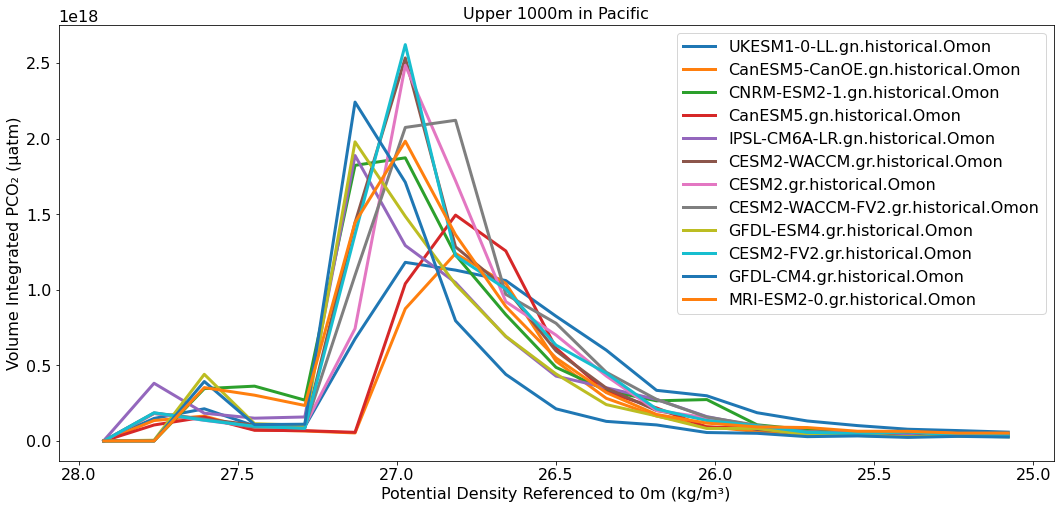

In [24]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=[16,8])
fig.tight_layout(pad = 3.5)
plt.rc('font', size = 16)
plt.rc('axes', titlesize= 16)    
plt.rc('axes', labelsize= 16)
plt.rc('figure', titlesize=16)

target = np.linspace(25, 28, 20)
binz = np.linspace(25, 28, 20)

conversion = 3.1536e7 * 83.3
ax_idx = 0
# for name, ds in dd.items():
for name, ds in dd_x_1000.items():
#     ax = axarr.flat[ax_idx]
#     if name != 'GFDL-ESM4.gr.historical.Omon':
#         if name != 'GFDL-CM4.gr.historical.Omon':
    ds = ds.assign_coords(**newcoords3)
    h2 = histogram(ds['sigma0'].sel(y = slice(-80, 30)), bins = [binz], weights = ds.PCO2.sel(y = slice(-80, 30))*ds.lev_bounds*A_pac.sel(y = slice(-80, 30))) 
    h2.plot(label = name, lw = 3)
ax.invert_xaxis()
#     ax.set_title(name)
#     ax_idx += 1
ax.set_xlabel('Potential Density Referenced to 0m (kg/m\u00b3)', fontsize = 16)
ax.set_ylabel('Volume Integrated PCO\u2082 (\u03BCatm)', fontsize = 16)
ax.set_title('Upper 1000m in Pacific')
plt.legend(
#     bbox_to_anchor=(1.05, 1), 
    loc='upper right'
#     , borderaxespad=0.
)

In [90]:
ds.PCO2.sel(y = slice(-80, -30))*ds.lev_bounds*A_pac.sel(y = slice(-80, -30))

<xarray.DataArray (lev: 46, y: 46, bnds: 2)>
dask.array<mul, shape=(46, 46, 2), dtype=float64, chunksize=(46, 46, 2), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 -79.5 -78.5 -77.5 -76.5 ... -33.5 -32.5 -31.5 -30.5
  * lev      (lev) float64 0.5058 1.556 2.668 3.856 ... 697.3 773.4 856.7 947.4
Dimensions without coordinates: bnds

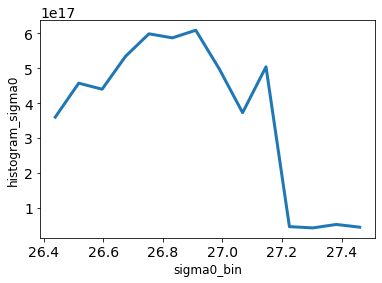

In [136]:

ds = dd_x_1000['UKESM1-0-LL.gn.historical.Omon'].assign_coords(**newcoords3)
h2 = histogram(ds['sigma0'].sel(y = slice(-90, 30)), bins = [binz], weights = ds.PCO2.sel(y = slice(-90, 30))*ds.lev_bounds*A_pac.sel(y = slice(-90, 30))) 
h2.plot(label = name, lw = 3)

In [129]:
h2.sigma0_bin


<xarray.DataArray 'sigma0_bin' (sigma0_bin: 14)>
array([26.439286, 26.517857, 26.596429, 26.675   , 26.753571, 26.832143,
       26.910714, 26.989286, 27.067857, 27.146429, 27.225   , 27.303571,
       27.382143, 27.460714])
Coordinates:
  * sigma0_bin  (sigma0_bin) float64 26.44 26.52 26.6 26.67 ... 27.3 27.38 27.46

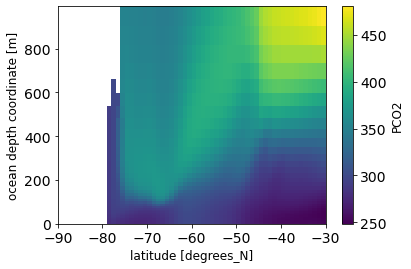

In [50]:
ds.PCO2.sel(y = slice(-80, -30)).plot()

In [38]:
newercoords2 = {'y':dd_A['GFDL-ESM4.gr.historical.Ofx'].mean(['x'],keep_attrs=True).areacello['y']}
newercoords2

<xarray.DataArray 'areacello' (y: 120)>
dask.array<getitem, shape=(120,), dtype=float32, chunksize=(120,), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 26.5 27.5 28.5 29.5
Attributes:
    cell_methods:   area: sum
    comment:        Model data on the 1x1 grid includes values in all cells f...
    interp_method:  conserve_order1
    long_name:      Grid-Cell Area
    original_name:  areacello
    standard_name:  cell_area
    units:          m²

In [94]:
d = ds.assign_coords(**newcoords3)
d

<xarray.Dataset>
Dimensions:     (y: 180, lev: 46, bnds: 2)
Coordinates:
  * y           (y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lev         (lev) float64 0.5058 1.556 2.668 3.856 ... 773.4 856.7 947.4
Dimensions without coordinates: bnds
Data variables:
    dissic      (lev, y) float64 dask.array<chunksize=(46, 180), meta=np.ndarray>
    fgco2       (y) float64 dask.array<chunksize=(180,), meta=np.ndarray>
    so          (lev, y) float64 dask.array<chunksize=(46, 180), meta=np.ndarray>
    talk        (lev, y) float64 dask.array<chunksize=(46, 180), meta=np.ndarray>
    thetao      (lev, y) float64 dask.array<chunksize=(46, 180), meta=np.ndarray>
    p           (lev, y) float64 dask.array<chunksize=(46, 180), meta=np.ndarray>
    insitutemp  (lev, y) float64 dask.array<chunksize=(46, 180), meta=np.ndarray>
    sigma2      (lev, y) float64 dask.array<chunksize=(46, 180), meta=np.ndarray>
    sigma0      (lev, y) float64 dask.array<chunksize=(46, 180), meta=np.ndarray>
    PCO2        (lev, y) float64 nan nan nan nan nan ... 240.1 239.6 238.9 238.4
    lev_bounds  (lev, bnds) float64 dask.array<chunksize=(46, 2), meta=np.ndarray>

In [95]:
d.PCO2.sel(y = slice(-80, -30))*d.lev_bounds*A_pac.sel(y = slice(-80, -30))

<xarray.DataArray (lev: 46, y: 50, bnds: 2)>
dask.array<mul, shape=(46, 50, 2), dtype=float64, chunksize=(46, 50, 2), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 -79.5 -78.5 -77.5 -76.5 ... -33.5 -32.5 -31.5 -30.5
  * lev      (lev) float64 0.5058 1.556 2.668 3.856 ... 697.3 773.4 856.7 947.4
Dimensions without coordinates: bnds